<a href="https://colab.research.google.com/github/nidhaloff/Mobile-Price-Prediction/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pylab import savefig
from sklearn.metrics import r2_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

1.1.0


In [147]:

train_data = pd.read_csv('/content/train.csv')   # '/content/Auto_data.csv'
test_data = pd.read_csv('/content/test.csv')
print(train_data.describe())
print(train_data.columns)

       battery_power       blue  ...         wifi  price_range
count    2000.000000  2000.0000  ...  2000.000000  2000.000000
mean     1238.518500     0.4950  ...     0.507000     1.500000
std       439.418206     0.5001  ...     0.500076     1.118314
min       501.000000     0.0000  ...     0.000000     0.000000
25%       851.750000     0.0000  ...     0.000000     0.750000
50%      1226.000000     0.0000  ...     1.000000     1.500000
75%      1615.250000     1.0000  ...     1.000000     2.250000
max      1998.000000     1.0000  ...     1.000000     3.000000

[8 rows x 21 columns]
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')


In [148]:
print(train_data.price_range[:10])

0    1
1    2
2    2
3    2
4    1
5    1
6    3
7    0
8    0
9    0
Name: price_range, dtype: int64


In [149]:
print(train_data.info())
print("="*50)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
battery_power    2000 non-null int64
blue             2000 non-null int64
clock_speed      2000 non-null float64
dual_sim         2000 non-null int64
fc               2000 non-null int64
four_g           2000 non-null int64
int_memory       2000 non-null int64
m_dep            2000 non-null float64
mobile_wt        2000 non-null int64
n_cores          2000 non-null int64
pc               2000 non-null int64
px_height        2000 non-null int64
px_width         2000 non-null int64
ram              2000 non-null int64
sc_h             2000 non-null int64
sc_w             2000 non-null int64
talk_time        2000 non-null int64
three_g          2000 non-null int64
touch_screen     2000 non-null int64
wifi             2000 non-null int64
price_range      2000 non-null int64
dtypes: float64(2), int64(19)
memory usage: 328.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000

In [150]:
test_cols = test_data.columns.to_numpy()
train_cols = train_data.columns.to_numpy()
print(len(train_cols), len(test_cols))

21 21


In [151]:
print(train_data.columns)
print(test_data.columns)

diff = set(test_cols) - set(train_cols)
print("diff: ", diff)

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Index(['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')
diff:  {'id'}


In [152]:
X = train_data.iloc[:, 0:len(train_cols)- 1]
y = train_data.iloc[:, -1]

X_std = X.std()
X_mean = X.mean()
y_std = y.std()
y_mean = y.mean()

X = (X - X.mean()) / X.std()
y = (y- y.mean()) / y.std()

X, y = X.to_numpy(), y.to_numpy()
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


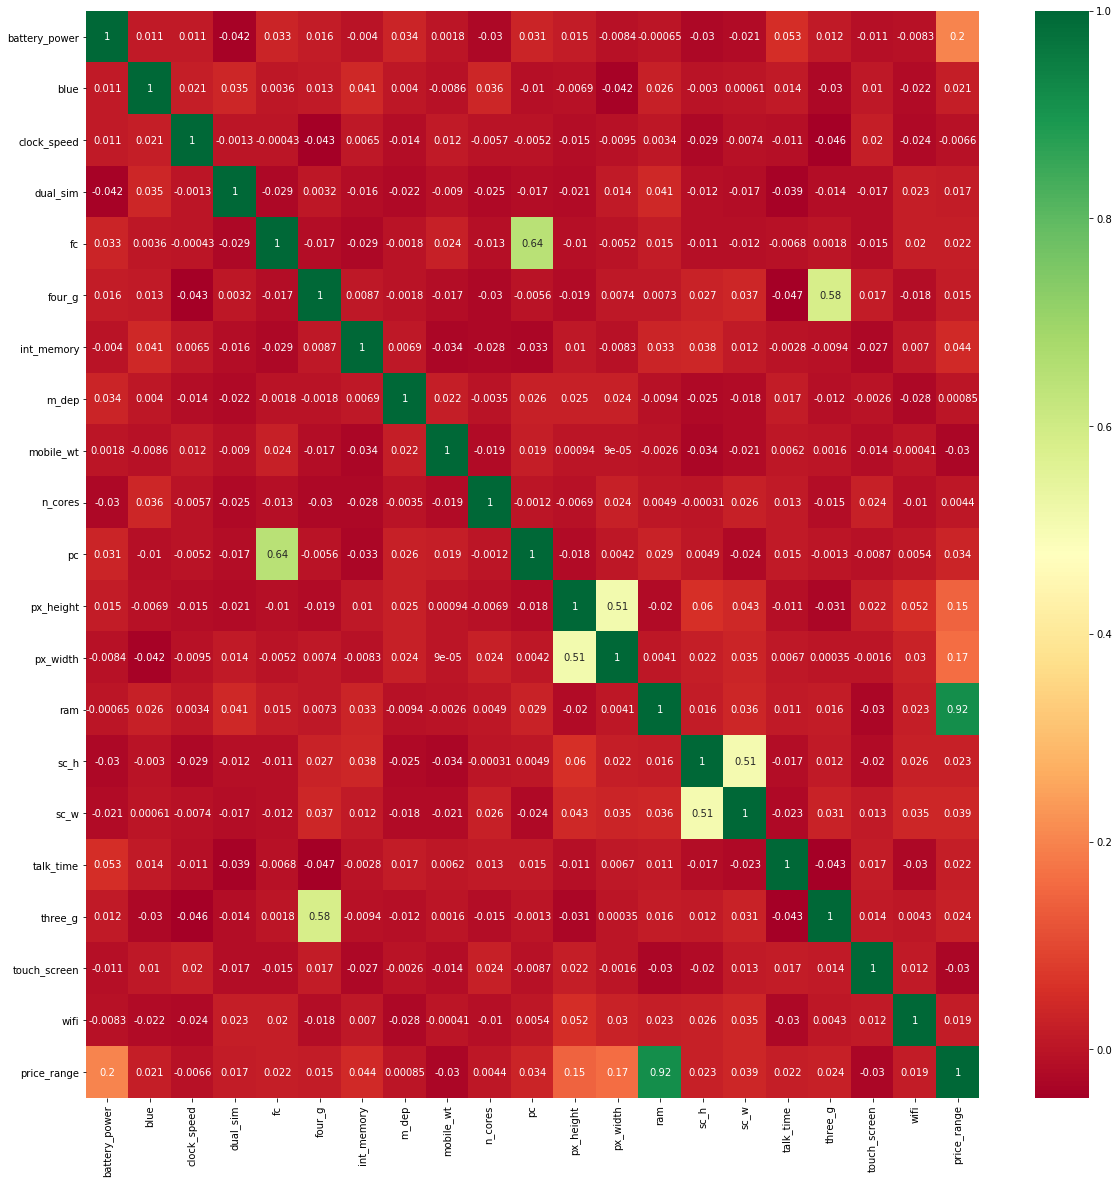

In [153]:
corr_matrix = train_data.corr()
top_corr_features = corr_matrix.index

plt.figure(figsize=(20, 20))

# plot the heatmap
h_map = sns.heatmap(train_data[top_corr_features].corr(), annot=True, cmap="RdYlGn")
h_map_fig = h_map.get_figure()
h_map_fig.savefig('h_map.jpg', dpi=400)

In [0]:
class MobilePricePredictor(nn.Module):
    def __init__(self, n_features, n_hidden, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, n_out)
        self.act = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)
        out = self.act(out)
        out = self.fc4(out)
        return out
    


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)
print(X_train.shape, y_train.shape, type(y_train), type(X_train))
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True) 
test_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=False)

torch.Size([1400, 20]) torch.Size([1400]) <class 'torch.Tensor'> <class 'torch.Tensor'>


In [0]:
m, n = X_train.shape

model = MobilePricePredictor(n, 100, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epochs):
    model.train()
    count = 0
    
    loss_list, iters, accuracy_list = [], [], []
    
    for e in range(epochs):
        running_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            out = model(X.float())
            loss = criterion(out, y.view(-1, 1))
            loss.backward()
            optimizer.step()
            count += 1
            running_loss += loss.item()
            if count % 50 == 0:
                iters.append(count)
                loss_list.append(loss.item())
                score = r2_score(y.numpy(), out.data[:,0].numpy())
                accuracy_list.append(score)
        print("running_loss= ", running_loss)
    print("Finished Traininig")
    return loss_list, iters, accuracy_list



def test():
    
    model.eval()
    mse = rmse = total = 0
    accuracy_list = []
    test_losses = []
    scores = []
    with torch.no_grad():

        for X, y in test_loader:

            pred = model(X.float())
            y_pred = pred.data[:,0].numpy()
            score = r2_score(y_pred, y.view(-1, 1).numpy())
            #print(f"type of y_pred= {type(y_pred)} and y= {type(y.numpy())}")
            #print(f"length of y_pred= {len(y_pred)} and for y= {len(y.numpy())}")
            loss = criterion(pred, y.view(-1, 1))
            mse = torch.sum((pred-y.view(-1, 1))**2) / len(y)
            rmse = torch.sqrt(mse).item()
            #print(f" mean squared error = {acc}")
            loss_rmse = torch.sqrt(loss)
            test_losses.append(loss_rmse.item())
            accuracy_list.append(rmse)
            scores.append(score)
            

    return accuracy_list, test_losses, scores



In [0]:
def show_results(losses, iters, *accs):
    plt.plot(iters, losses, color="blue")
    plt.xlabel("iterations")
    plt.ylabel("losses")
    plt.title("loss over iterations")
    plt.show()
    
    if accs:
        
        #iters = iters[:len(*accs)]
        #print("iters length in show results: ", len(iters))
        plt.plot(iters, *accs, color="red")
        plt.xlabel("iterations")
        plt.ylabel("accuracy")
        plt.title("Accuracy over iterations")
        plt.show()


running_loss=  0.11567694880068302
running_loss=  0.11499624792486429
running_loss=  0.11502154311165214
running_loss=  0.11554866516962647
running_loss=  0.11420580418780446
running_loss=  0.11434165062382817
running_loss=  0.11457988154143095
running_loss=  0.11332885595038533
running_loss=  0.11332155950367451
running_loss=  0.11306994128972292
running_loss=  0.11315641831606627
running_loss=  0.1122780847363174
running_loss=  0.11246575647965074
running_loss=  0.11174339475110173
running_loss=  0.1116043422371149
running_loss=  0.11090666335076094
running_loss=  0.11178311938419938
running_loss=  0.11050520604476333
running_loss=  0.11094019701704383
running_loss=  0.10995877673849463
running_loss=  0.10952753946185112
running_loss=  0.1103759203106165
running_loss=  0.10919638257473707
running_loss=  0.10879755299538374
running_loss=  0.10868773609399796
running_loss=  0.10840923665091395
running_loss=  0.10788440052419901
running_loss=  0.10803979216143489
running_loss=  0.107431

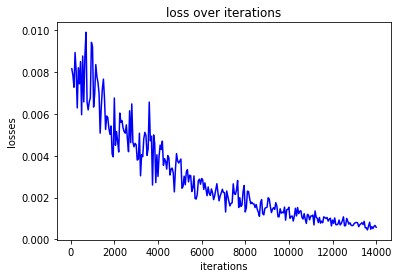

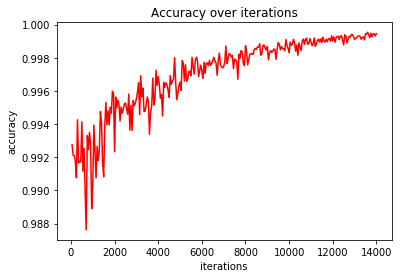

In [189]:
losses, iters, train_scores = train(1000)
accs, test_losses, scores = test()
print("loss_list => ", losses[:20])
print("="*50)
print("iterations => ", iters[:20])
print("="*50)
print("accuracy_list => ", accs[:20])
print("="*50)
print("test_loss_list => ", test_losses[:20])
print("="*50)
print("test scores", scores[:30])
print("="*50)
print("train scores => ", train_scores[:30])
print("="*50)
#rint(f"lenght losses= {len(losses)} and length of iters= {len(iters)} and length of accuracy list = {len(accs)} and scores= {len(scores)} and train_score= {len(train_scores)}")
show_results(losses, iters, train_scores)

In [183]:
from sklearn.linear_model import LinearRegression
    
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [184]:
print(lr.score(X_train.numpy(), y_train.numpy()))

0.9184887371633569


In [185]:
print(lr.score(X_test.numpy(), y_test.numpy()))

0.9181733571395547


In [190]:

with torch.no_grad():

    predictions = model(X_test.float())
#     print(predictions.shape)
    predictions = predictions.data[:,0]
    
    score = r2_score(predictions.numpy(), y_test.numpy())
    print("test score= ", score)
    
    df = pd.DataFrame({"predictions": predictions.numpy(), "targets": y_test.numpy()})
    print(df.head(10))

test score=  0.898264833300396
   predictions   targets
0    -1.212636 -1.341305
1     0.242039  0.447102
2    -0.467148 -0.447102
3     1.265630  1.341305
4     0.203184 -0.447102
5    -0.152195 -0.447102
6    -0.278854  0.447102
7    -1.107005 -1.341305
8     0.998123  1.341305
9    -0.196449 -0.447102


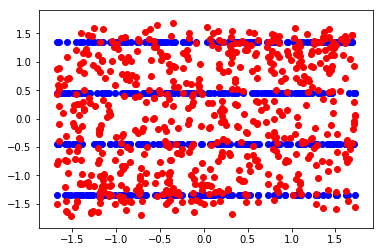

In [188]:

plt.scatter(X_test.data[:,0].numpy(), y_test, c="b")
plt.scatter(X_test.data[:,0].numpy(), predictions, c="r")
plt.show()